In [3]:
using Plots, GLM, RDatasets

In [4]:
function holding_cost(x,y,factor) 
    return -1*factor*(div(x,y)+1) # where x is pounds of material, and y is [lbs/gaylord]
end

function shipping_cost(x,y)
    shipping_factor = 1# place holder for shipping cost [$/(gaylord sent)]
    return -1*shipping_factor*(div(x,y)+1)# where x is pounds of material, and y is [lbs/gaylord]
end

function pre_process_cost(x,t,hFactor,P0)
    ## Cost to materials, and normalized by weight
    # [$/lb]
    m = -0.07 # manual demanufacturing 
    s = -0.04 # shredding 
    f = -0.03 # metal finder 

    ## Price to sell for TV's
    # price per pound multiplied by percentage of TV unit is
    steel     = 0.06 * 0.0299 
    boards2   = 0.35 * 0.0699
    wire      = 0.46 * 0.0099
    plastic   = 0.07 * 0.0599
    cones     = 0.42 * 0.0249
    dwire     = 0.65 * 0.0099
    pcopper   = 0.08 * 0.0240
    palum     = 0.45 * 0.0019
    tube      = 0.06 * 0.1499
    leadglass = -0.13 * 0.62
    selling_price = sum([steel boards2 wire plastic cones dwire pcopper palum tube leadglass])
    
    return  x*(P0+m+s+f+selling_price) + t*holding_cost(x,451,hFactor) + shipping_cost(x,21600)
end

function post_process_cost(x, proccess_t, t,hFactor,P0)
    orig_weight = x/0.62
    accum_cost = pre_process_cost(orig_weight, proccess_t, hFactor,P0)
    
    return t*holding_cost(x,451,hFactor) + accum_cost
end

post_process_cost (generic function with 1 method)

In [46]:
n = 1000
P0 = 1
hF = 2.36 #cost of space no change
pre_cost = zeros(n,n)
weight_spread = linspace(450,450*200,n)
time = linspace(1,n,n)

for i=1:n
    for j=1:n
        pre_cost[i,j] = pre_process_cost(weight_spread[i], time[j],hF,P0)
    end
end


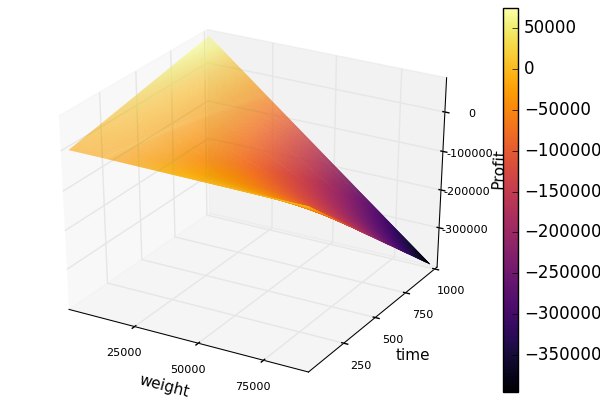

In [17]:
plot(weight_spread, time, pre_cost,st=:surface,xlab = "weight", ylab = "time", zlab = "Profit")

In [31]:
savefig("profit_surface.png")

Plot level curve to see where profit hits 0


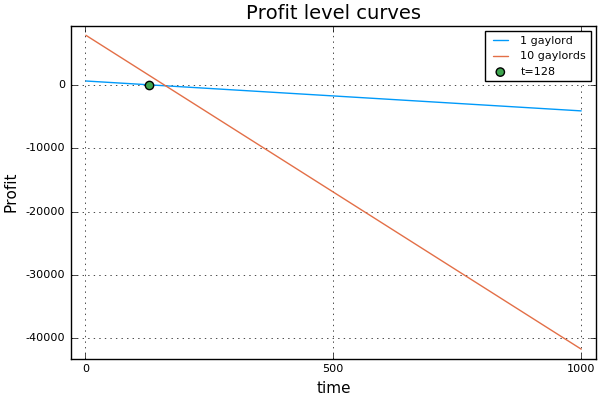

In [47]:
plot(time, vec(pre_cost[4,:]),xlab = "time", ylab = "Profit", label="1 gaylord")
plot!(time, vec(pre_cost[100,:]),label="10 gaylords")
title!("Profit level curves")
scatter!([128],[0], label="t=128")

In [33]:
savefig("profit_level_curves.png")

In [73]:
data = DataFrame(X=time, Y=vec(pre_cost[5,:]));

In [70]:
lm1 = fit(LinearModel, Y ~ X, data)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredQR{Float64}},Array{Float64,2}}

Formula: Y ~ 1 + X

Coefficients:
             Estimate   Std.Error     t value Pr(>|t|)
(Intercept)   605.098 4.61294e-14  1.31174e16   <1e-99
X               -4.72 7.98385e-17 -5.91193e16   <1e-99


# Current Facility

In [91]:
n = 50
P0 = 1
nc_hF = 31.89  # Holding cost of not changing facility
nc_post_cost = zeros(n,n)
weight_spread = linspace(.62*450,.62*450*100,n)
time = linspace(1,100,n)
pTime = 5

for i=1:n
    for j=1:n
        nc_post_cost[i,j] = post_process_cost(weight_spread[i], pTime, time[j], nc_hF, P0)
    end
end

In [95]:
nc_pre_cost = zeros(n,pTime)
pre_cost_time = linspace(1,pTime,pTime)
pre_weight = linspace(450,450*100,n)
for i=1:n
    for j=1:pTime
        nc_pre_cost[i,j] = pre_process_cost(pre_weight[i], pre_cost_time[j], nc_hF, P0)
    end
end


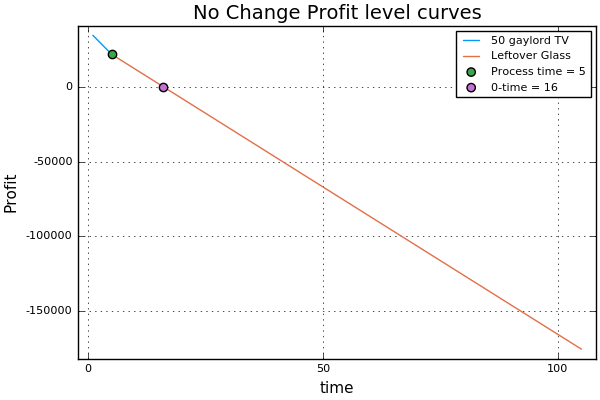

In [96]:
plot(pre_cost_time, vec(nc_pre_cost[50,:]), label="50 gaylord TV")
plot!(time+pTime, vec(nc_post_cost[50,:]),xlab = "time", ylab = "Profit", label="Leftover Glass")

scatter!([pTime],[nc_pre_cost[50,pTime]],label="Process time = 5")
scatter!([11+pTime],[0],label="0-time = 16")
title!("No Change Profit level curves")

In [97]:
savefig("profit_piecewise_no_change.png")

In [98]:
data2 = DataFrame(X=time, Y=vec(nc_post_cost[50,:]))
lm2 = fit(LinearModel, Y ~ X, data2)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredQR{Float64}},Array{Float64,2}}

Formula: Y ~ 1 + X

Coefficients:
             Estimate   Std.Error     t value Pr(>|t|)
(Intercept)   21990.1 1.47839e-11  1.48744e15   <1e-99
X            -1977.18 2.53529e-13 -7.79865e15   <1e-99


# Full Change

In [99]:
n = 50
P0 = 1
f_hF = 12.02  # Holding cost of not changing facility
f_post_cost = zeros(n,n)
weight_spread = linspace(.62*450,.62*450*100,n)
time = linspace(1,100,n)
pTime = 5

for i=1:n
    for j=1:n
        f_post_cost[i,j] = post_process_cost(weight_spread[i], pTime, time[j], f_hF, P0)
    end
end

In [100]:
f_pre_cost = zeros(n,pTime)
pre_cost_time = linspace(1,pTime,pTime)
pre_weight = linspace(450,450*100,n)
for i=1:n
    for j=1:pTime
        f_pre_cost[i,j] = pre_process_cost(pre_weight[i], pre_cost_time[j], f_hF, P0)
    end
end


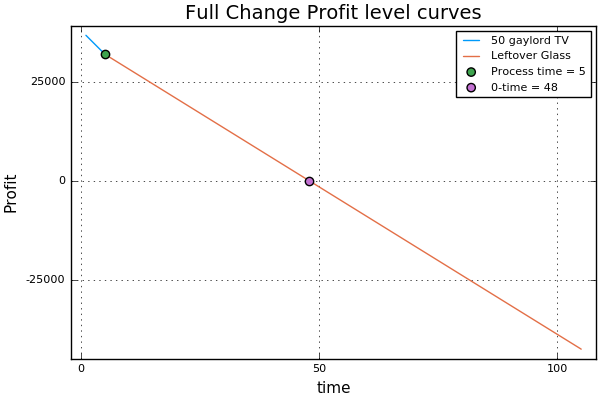

In [102]:
plot(pre_cost_time, vec(f_pre_cost[50,:]), label="50 gaylord TV")
plot!(time+pTime, vec(f_post_cost[50,:]),xlab = "time", ylab = "Profit", label="Leftover Glass")

scatter!([pTime],[f_pre_cost[50,pTime]],label="Process time = 5")
scatter!([42.84+pTime],[0],label="0-time = 48")
title!("Full Change Profit level curves")

In [105]:
savefig("profit_piecewise_change.png")

In [88]:
data3 = DataFrame(X=time, Y=vec(f_post_cost[50,:]))
lm3 = fit(LinearModel, Y ~ X, data3)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredQR{Float64}},Array{Float64,2}}

Formula: Y ~ 1 + X

Coefficients:
             Estimate   Std.Error     t value Pr(>|t|)
(Intercept)   31925.1 1.94215e-12   1.6438e16   <1e-99
X             -745.24 3.33059e-14 -2.23756e16   <1e-99



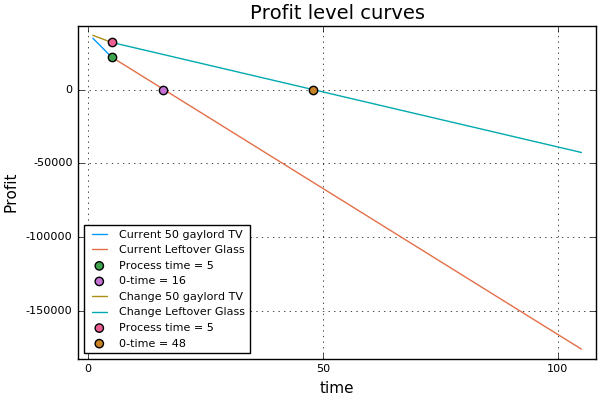

In [104]:
plot(pre_cost_time, vec(nc_pre_cost[50,:]), label="Current 50 gaylord TV")
plot!(time+pTime, vec(nc_post_cost[50,:]),xlab = "time", ylab = "Profit", label="Current Leftover Glass")

scatter!([pTime],[nc_pre_cost[50,pTime]],label="Process time = 5")
scatter!([11+pTime],[0],label="0-time = 16")

plot!(pre_cost_time, vec(f_pre_cost[50,:]), label="Change 50 gaylord TV")
plot!(time+pTime, vec(f_post_cost[50,:]),xlab = "time", ylab = "Profit", label="Change Leftover Glass")

scatter!([pTime],[f_pre_cost[50,pTime]],label="Process time = 5")
scatter!([42.84+pTime],[0],label="0-time = 48")
title!("Profit level curves")

In [106]:
savefig("profit_piecewise_no.png")